In [22]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline


In [23]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()


In [24]:
print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

# Find the unique numbers from the train labels - there are 10 [0..9]
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)



Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5,1,'Ground Truth : 9')

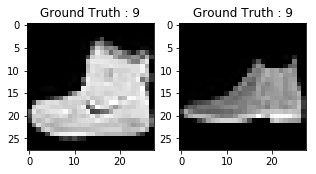

In [25]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))


In [26]:
"""
As you could see in the above plot, the images are grayscale images have pixel values that range from 0 to 255. 
Also, these images have a dimension of 28 x 28. As a result, you'll need to preprocess the data before you feed it into the model. 

As a first step, convert each 28 x 28 image of the train and test set into a matrix of size 28 x 28 x 1 which is fed into 
the network.
"""
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape
"""
The data right now is in an int8 format, so before you feed it into the network you need to convert its type to float32, 
and you also have to rescale the pixel values in range 0 - 1 inclusive. So let's do that!
"""
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.


In [27]:
"""
Now you need to convert the class labels into a one-hot encoding vector.
In one-hot encoding, you convert the categorical data into a vector of numbers. The reason why you convert the categorical 
data in one hot encoding is that machine learning algorithms cannot work with categorical data directly. You generate 
one boolean column for each category or class. Only one of these columns could take on the value 1 for each sample. 
Hence, the term one-hot encoding.

For your problem statement, the one hot encoding will be a row vector, and for each image, it will have a dimension of 1 x 10. 
The important thing to note here is that the vector consists of all zeros except for the class that it represents, 
and for that, it is 1. For example, the ankle boot image that you plotted above has a label of 9, so for all the ankle 
boot images, the one hot encoding vector would be [0 0 0 0 0 0 0 0 1 0].

So let's convert the training and testing labels into one-hot encoding vectors:
"""
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])


Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [28]:
"""
This last step is a crucial one. In machine learning or any data specific task, you should partition the data correctly. 
For the model to generalize well, you split the training data into two parts, one designed for training and another 
one for validation. In this case, you will train the model on 80\% of the training data and validate it on 20\% of 
the remaining training data. This will also help to reduce overfitting since you will be validating the model on the 
data it would not have seen in training phase, which will help in boosting the test performance.
"""

train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [30]:
"""
The images are of size 28 x 28. You convert the image matrix to an array, rescale it between 0 and 1, reshape it so that 
it's of size 28 x 28 x 1, and feed this as an input to the network.

You'll use three convolutional layers:

The first layer will have 32-3 x 3 filters,
The second layer will have 64-3 x 3 filters and
The third layer will have 128-3 x 3 filters.
"""
#import modules to train the model
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

"""
You will use a batch size of 64 using a higher batch size of 128 or 256 is also preferable it all depends on the memory. 
It contributes massively to determining the learning parameters and affects the prediction accuracy. You will train 
the network for 20 epochs.
"""

batch_size = 64
epochs = 20
num_classes = 10


In [31]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))


In [33]:
"""
After the model is created, you compile it using the Adam optimizer, one of the most popular optimization algorithms. 
You can read more about this optimizer here. Additionally, you specify the loss type which is categorical cross entropy 
which is used for multi-class classification, you can also use binary cross-entropy as the loss function. 
Lastly, you specify the metrics as accuracy which you want to analyze while the model is training.
"""
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

"""
Let's visualize the layers that you created in the above step by using the summary function. This will show some 
parameters (weights and biases) in each layer and also the total parameters in your model.
"""
fashion_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
__________

In [34]:
"""
It's finally time to train the model with Keras' fit() function! The model trains for 20 epochs. 
The fit() function will return a history object; By storying the result of this function in fashion_train, 
you can use it later to plot the accuracy and loss function plots between training and validation which 
will help you to analyze your model's performance visually.
"""
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 211s 4ms/step - loss: 0.4585 - acc: 0.8330 - val_loss: 0.3137 - val_acc: 0.8861
Epoch 2/20
48000/48000 [==============================] - 227s 5ms/step - loss: 0.2792 - acc: 0.8977 - val_loss: 0.2956 - val_acc: 0.8924
Epoch 3/20
48000/48000 [==============================] - 208s 4ms/step - loss: 0.2343 - acc: 0.9135 - val_loss: 0.2577 - val_acc: 0.9059
Epoch 4/20
48000/48000 [==============================] - 211s 4ms/step - loss: 0.2045 - acc: 0.9242 - val_loss: 0.2386 - val_acc: 0.9170
Epoch 5/20
48000/48000 [==============================] - 196s 4ms/step - loss: 0.1794 - acc: 0.9337 - val_loss: 0.2194 - val_acc: 0.9225
Epoch 6/20
48000/48000 [==============================] - 194s 4ms/step - loss: 0.1578 - acc: 0.9411 - val_loss: 0.2237 - val_acc: 0.9213
Epoch 7/20
48000/48000 [==============================] - 180s 4ms/step - loss: 0.1358 - acc: 0.9493 - val_loss: 0.2406 - 

In [35]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 0.4860444114053622
Test accuracy: 0.9136


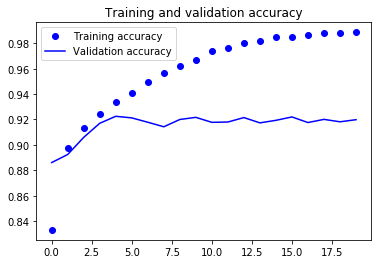

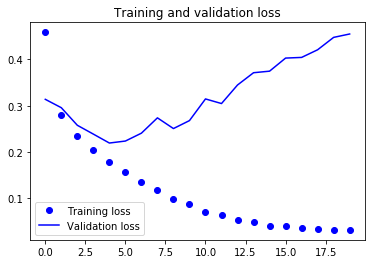

In [36]:
"""
The test accuracy looks impressive. It turns out that your classifier does better than the benchmark that was reported here, 
which is an SVM classifier with mean accuracy of 0.897. Also, the model does well compared to some of the deep learning 
models mentioned on the GitHub profile of the creators of fashion-MNIST dataset.
However, you saw that the model looked like it was overfitting. Are these results really all that good?
Let's put your model evaluation into perspective and plot the accuracy and loss plots between training and validation data:
"""
accuracy = fashion_train.history['acc']
val_accuracy = fashion_train.history['val_acc']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [39]:
type(accuracy),len(accuracy),accuracy[0]

(list, 20, 0.8330416666666667)

In [40]:
"""
You can add a dropout layer to overcome the problem of overfitting to some extent. Dropout randomly turns off a fraction of 
neurons during the training process, reducing the dependency on the training set by some amount. How many fractions of neurons 
you want to turn off is decided by a hyperparameter, which can be tuned accordingly. This way, turning off some neurons will 
not allow the network to memorize the training data since not all the neurons will be active at the same time and the 
inactive neurons will not be able to learn anything.

So let's create, compile and train the network again but this time with dropout. And run it for 20 epochs with a batch 
size of 64.
"""
batch_size = 64
epochs = 20
num_classes = 10


In [41]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.4))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))           
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(num_classes, activation='softmax'))
fashion_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [43]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
fashion_train_dropout = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 208s 4ms/step - loss: 0.6090 - acc: 0.7730 - val_loss: 0.3766 - val_acc: 0.8592
Epoch 2/20
48000/48000 [==============================] - 201s 4ms/step - loss: 0.3779 - acc: 0.8589 - val_loss: 0.3124 - val_acc: 0.8822
Epoch 3/20
48000/48000 [==============================] - 200s 4ms/step - loss: 0.3281 - acc: 0.8786 - val_loss: 0.2781 - val_acc: 0.8985
Epoch 4/20
48000/48000 [==============================] - 200s 4ms/step - loss: 0.2971 - acc: 0.8892 - val_loss: 0.2581 - val_acc: 0.9048
Epoch 5/20
48000/48000 [==============================] - 205s 4ms/step - loss: 0.2789 - acc: 0.8956 - val_loss: 0.2561 - val_acc: 0.9088
Epoch 6/20
48000/48000 [==============================] - 236s 5ms/step - loss: 0.2673 - acc: 0.9010 - val_loss: 0.2409 - val_acc: 0.9112
Epoch 7/20
48000/48000 [==============================] - 232s 5ms/step - loss: 0.2562 - acc: 0.9051 - val_loss: 0.2336 - 

In [48]:
#
# Save the model so we don't have to retrain it each time
#
fashion_model.save("fashion_model_dropout.h5py")

"""
To reload the model use the following command
myModel = keras.models.load_model(filepath)
"""

"""
Model Evaluation on the Test Set
Finally, let's also evaluate your new model and see how it performs!
"""

test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


10000/10000 [==============================] - 14s 1ms/step
Test loss: 0.2218779006898403
Test accuracy: 0.9218


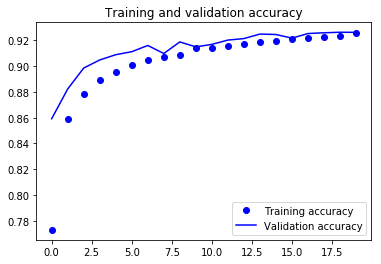

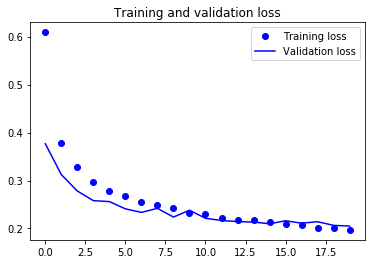

In [49]:
#
# Now replot the accuracy after adding the dropout
#
accuracy = fashion_train_dropout.history['acc']
val_accuracy = fashion_train_dropout.history['val_acc']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [51]:
"""
Since the predictions you get are floating point values, it will not be feasible to compare the predicted labels with 
true test labels. So, you will round off the output which will convert the float values into an integer. 
Further, you will use np.argmax() to select the index number which has a higher value in a row.

For example, let's assume a prediction for one test image to be 0 1 0 0 0 0 0 0 0 0, the output for this should be 
a class label 1.
"""
predicted_classes = fashion_model.predict(test_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_Y.shape


((10000,), (10000,))

Found 9176 correct labels


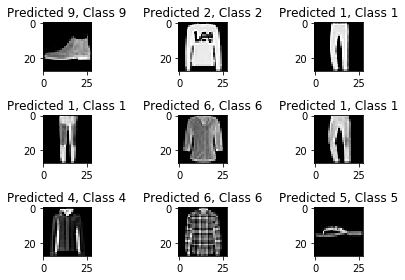

In [52]:
#
# Show the correctly predicted labels
#
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()
    

Found 824 incorrect labels


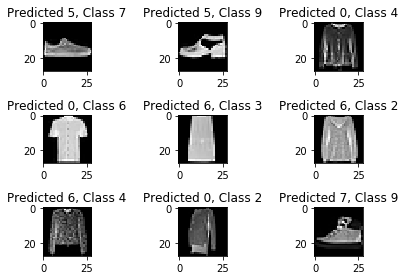

In [53]:
#
# Now show the incorrectly predicted labels
#
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()


In [54]:
"""
Classification report will help us in identifying the misclassified classes in more detail. You will be able to observe 
for which class the model performed bad out of the given ten classes.
"""

from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))


             precision    recall  f1-score   support

    Class 0       0.79      0.86      0.82      1000
    Class 1       0.99      0.98      0.99      1000
    Class 2       0.91      0.85      0.88      1000
    Class 3       0.92      0.93      0.92      1000
    Class 4       0.88      0.88      0.88      1000
    Class 5       0.99      0.98      0.99      1000
    Class 6       0.77      0.77      0.77      1000
    Class 7       0.97      0.98      0.97      1000
    Class 8       0.99      0.98      0.99      1000
    Class 9       0.98      0.97      0.98      1000

avg / total       0.92      0.92      0.92     10000

